In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask.distributed import LocalCluster, Client

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

SEED=0
np.random.seed(SEED)

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [9]:
forecasting_horizon = 30

In [10]:
def load_and_preprocess_daily_data(start_index, end_index):
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="mean")
    esios_df = esios_provider.get_all_series(freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="sum")
    ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", start_index=start_index, end_index=end_index)
    coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", start_index=start_index, end_index=end_index)
    co2_df = icap_provider.get_series(icap_tickers[0], freq="D", start_index=start_index, end_index=end_index)

    contamination = 0.01
    esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
    lags = [1, 2, 6, 7, 13, 14, 28, 30, 31]
    date_features = ["day", "day_of_week", "week_of_year", "month"]

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)
    y_date_features = df_date_features.iloc[:, 0]
    X_date_features = df_date_features.iloc[:, 1:]

    y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test = train_test_split(y_date_features, X_date_features, test_size=forecasting_horizon)

    return y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test

In [11]:
y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test = load_and_preprocess_daily_data(start_index="2021-04-01", end_index="2023-03-31")

In [12]:
model = RandomForestRegressor()
model.fit(X_date_features_train, y_date_features_train)

RandomForestRegressor()

In [13]:
X_date_features_train

,PRECIO_MERCADO_SPOT_DIARIO_shift1,PRECIO_MERCADO_SPOT_DIARIO_shift2,PRECIO_MERCADO_SPOT_DIARIO_shift6,PRECIO_MERCADO_SPOT_DIARIO_shift7,PRECIO_MERCADO_SPOT_DIARIO_shift13,PRECIO_MERCADO_SPOT_DIARIO_shift14,PRECIO_MERCADO_SPOT_DIARIO_shift28,PRECIO_MERCADO_SPOT_DIARIO_shift30,PRECIO_MERCADO_SPOT_DIARIO_shift31,DEMANDA_REAL,...,GENERACIÓN_MEDIDA_CICLO_COMBINADO,GENERACIÓN_MEDIDA_CARBÓN,DAILY_TTF_PRICE,DAILY_COAL_PRICE,CO2_EUA_PRICE,month,day,hour,day_of_week,week_of_year
DATE,,,,,,,,,,,,,,,,,,,,,
2022-05-15,190.390000,204.092500,209.308750,172.679167,188.108750,177.434167,106.213750,198.319583,219.804167,529718.500000,...,41640.709,13597.828,96.880,318.35,88.06,5,15,0,6,19
2021-07-16,87.585000,82.740417,90.785417,93.785417,93.784583,99.457500,92.780833,94.688750,91.596667,720113.500000,...,72127.795,8822.501,34.840,131.30,52.78,7,16,0,4,28
2021-09-02,133.470833,130.280000,119.274583,122.815417,117.022917,115.292083,101.112500,106.449583,103.381667,694892.333333,...,175227.388,19377.839,51.915,162.15,61.48,9,2,0,3,35
2021-06-13,77.433333,82.562917,80.407500,67.924167,88.166667,72.681667,28.006250,71.311250,60.470833,588703.166667,...,84668.682,15280.629,27.845,106.60,52.59,6,13,0,6,23
2021-07-13,86.547500,89.865833,98.177083,93.656250,94.148333,93.315417,91.596667,79.785833,77.433333,704088.666667,...,79825.515,9251.613,35.465,128.00,52.77,7,13,0,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,190.459167,197.221667,205.555833,220.402083,225.261250,228.248750,217.852500,196.744583,218.212083,705876.166667,...,141067.927,10851.493,79.595,157.50,96.21,2,7,0,0,6
2022-08-28,163.150833,175.582083,175.514583,140.858333,145.084583,147.849583,116.160417,141.847083,167.994167,579246.416667,...,218396.133,20535.340,339.195,364.85,89.93,8,28,0,6,34
2021-05-26,76.415000,68.743333,80.315417,77.513333,60.470833,53.365417,74.267500,76.393750,61.901667,660716.833333,...,93464.041,18143.500,26.425,89.40,53.59,5,26,0,2,21


In [14]:
y_pred = model.predict(X_date_features_test)

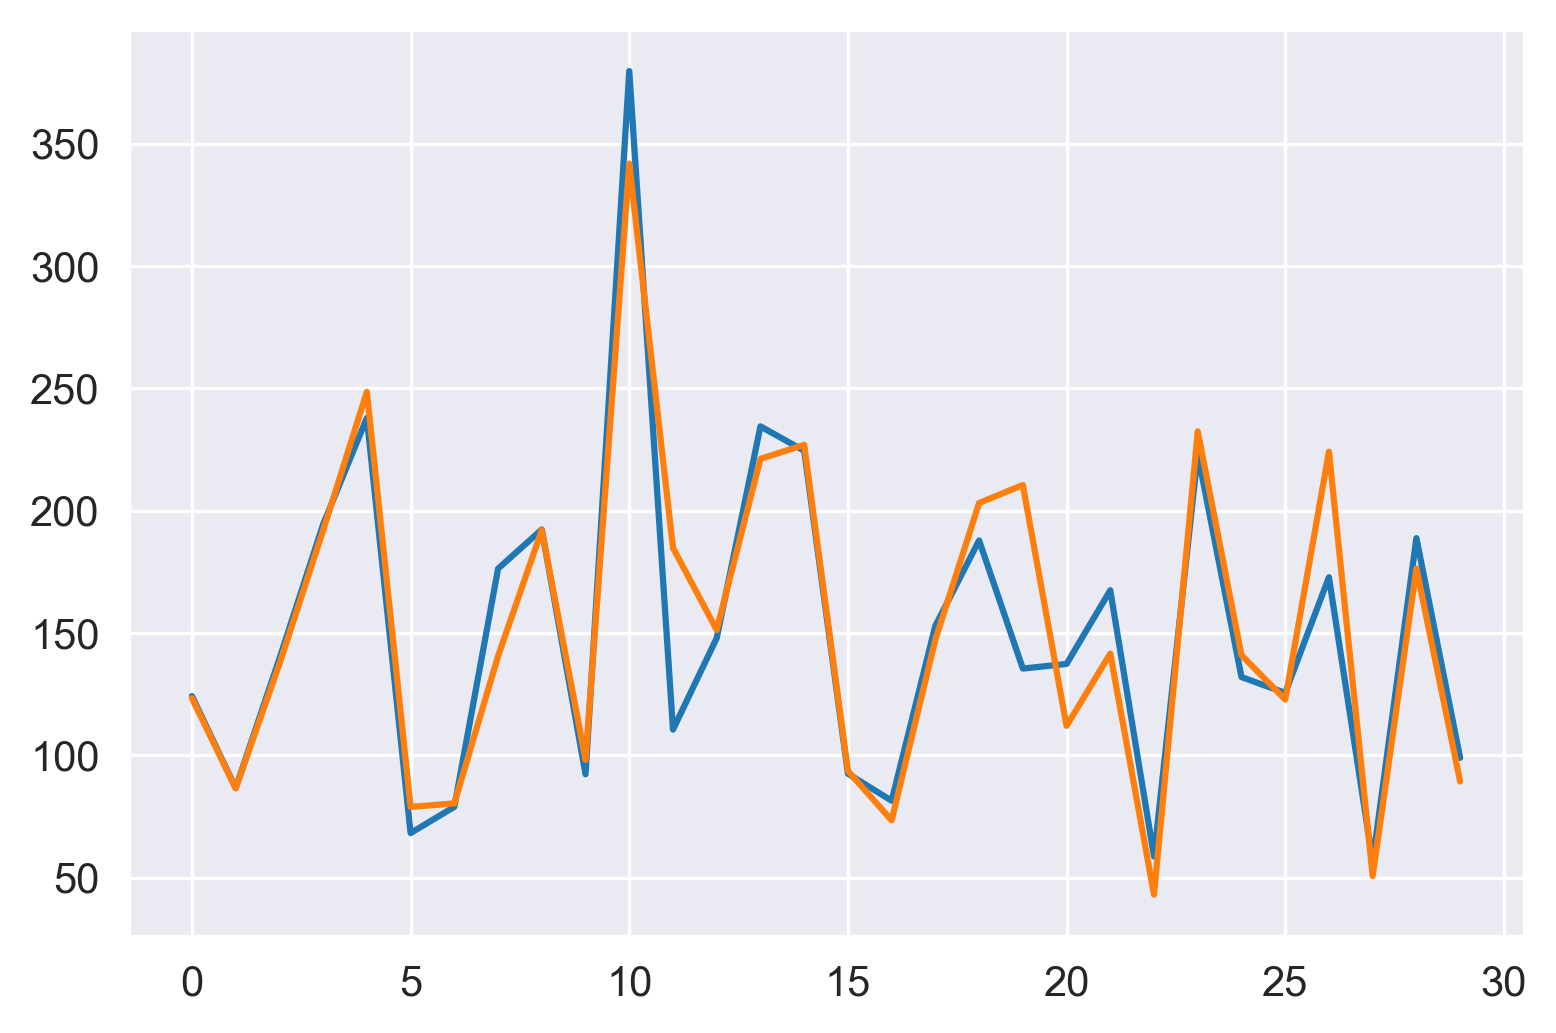

In [17]:
plt.plot(y_pred)
plt.plot(y_date_features_test.to_numpy())